In [1]:
import sys
import glob
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile
import imagecodecs
import imageio

In [8]:
sys.path.append('../sartorius/package/helper_package/')

In [9]:
#pip install pycocotools
#pip install imagecodecs
#pip install scikit-image

In [10]:
from livecell_dataset import LiveCell_Dataset

In [11]:
SHSY5Y_LIVECELL_TRAIN_IMAGE_FOLDER = './sartorius-cell-instance-segmentation/LIVECell_dataset_2021/images/livecell_train_val_images/SHSY5Y/'
SHSY5Y_LIVECELL_TRAIN_ANNOTATION_PATH = './sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/shsy5y/livecell_shsy5y_train.json'
SHSY5Y_LIVECELL_VAL_ANNOTATION_PATH = './sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/shsy5y/livecell_shsy5y_val.json'

In [12]:
SHAPE_TARGET = (576, 704)
SHAPE = (520, 704)

In [13]:
livecell_dataset = LiveCell_Dataset(image_folder=SHSY5Y_LIVECELL_TRAIN_IMAGE_FOLDER, 
                                    train_annotation_path=SHSY5Y_LIVECELL_TRAIN_ANNOTATION_PATH,
                                    val_annotation_path=SHSY5Y_LIVECELL_VAL_ANNOTATION_PATH,
                                    shape_target=SHAPE_TARGET,
                                    shape=SHAPE)

In [14]:
print('Number of train SHSY5Y images: ', len(livecell_dataset.train_image_df))
print('Number of val SHSY5Y images: ', len(livecell_dataset.val_image_df))

Number of train SHSY5Y images:  449
Number of val SHSY5Y images:  79


In [15]:
livecell_dataset.train_annot_df.head()

,segmentation,area,iscrowd,image_id,bbox,category_id,id
1564018,"[[431.64, 126.36, 439.47, 131.9, 439.08, 136.4...",300.0471,0,1564017,"[427.25, 126.36, 18.899999999999977, 42.769999...",1,1564018
1564019,"[[279.35, 263.81, 282.28, 264.54, 284.72, 265....",223.89695,0,1564017,"[253.26, 263.1, 38.79000000000002, 9.389999999...",1,1564019
1564020,"[[291.16, 262.34, 298.03, 262.8, 299.86, 260.8...",129.8141,0,1564017,"[282.32, 260.36, 22.889999999999986, 14.610000...",1,1564020
1564021,"[[278.04, 241.57, 288.86, 242.69, 294.08, 238....",333.7615,0,1564017,"[277.3, 234.48, 39.90999999999997, 20.14000000...",1,1564021
1564022,"[[182.24, 30.73, 187.01, 19.99, 184.33, 13.43,...",234.7215,0,1564017,"[170.17, 0.0, 16.840000000000003, 30.9]",1,1564022


In [16]:
livecell_dataset.train_image_df.head()

,url,file_name,height,width,original_filename,id
0,https://darwin.v7labs.com/api/images/37815/ori...,SHSY5Y_Phase_C10_2_00d04h00m_3.tif,520,704,SHSY5Y_Phase_C10_2_00d04h00m_3.png,1564017
1,https://darwin.v7labs.com/api/images/108474/or...,SHSY5Y_Phase_B10_1_03d12h00m_2.tif,520,704,SHSY5Y_Phase_B10_1_03d12h00m_2.png,1420519
2,https://darwin.v7labs.com/api/images/922455/or...,SHSY5Y_Phase_D10_1_00d00h00m_4.tif,520,704,SHSY5Y_Phase_D10_1_00d00h00m_4.png,1419396
3,https://darwin.v7labs.com/api/images/47611/ori...,SHSY5Y_Phase_B10_2_01d12h00m_1.tif,520,704,SHSY5Y_Phase_B10_2_01d12h00m_1.png,1498293
4,https://darwin.v7labs.com/api/images/47647/ori...,SHSY5Y_Phase_D10_1_02d08h00m_1.tif,520,704,SHSY5Y_Phase_D10_1_02d08h00m_1.png,1439054


In [17]:
def rle_decode_by_image_id(image_id, df):
    SHAPE = (520, 704)
    rows = df.loc[df['id'] == image_id]
    
    # Image shape
    mask = np.full(shape=[len(rows), np.prod(SHAPE)], fill_value=0, dtype=np.uint8)
    
    for idx, (_, row) in enumerate(rows.iterrows()):
        s = row['annotation'].split()
        starts, lengths = [np.array(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            mask[idx, lo:hi] = True
        
    mask = mask.reshape([len(rows), *SHAPE])
    mask = np.moveaxis(mask, 0, 2)
    
    return mask

## Count instances per image

In [18]:
ins_per_img = livecell_dataset.train_annot_df.groupby('image_id').size()

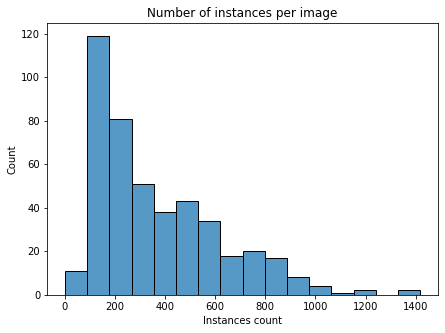

In [19]:
fig = plt.figure(figsize=(7, 5))

sns.histplot(x=ins_per_img.values)
plt.title('Number of instances per image')
plt.xlabel('Instances count')

plt.show()

In [20]:
livecell_dataset.convert_polygon_to_rle()

100%|██████████| 28199/28199 [01:18<00:00, 360.17it/s]


In [21]:
livecell_dataset.train_annot_df.head()

,segmentation,area,iscrowd,image_id,bbox,category_id,id
1564018,89136 1 89837 5 90540 8 91244 9 91949 9 92653 ...,300.0471,0,1564017,"[427.25, 126.36, 18.899999999999977, 42.769999...",1,1564018
1564019,185410 2 186114 13 186132 7 186817 29 187520 3...,223.89695,0,1564017,"[253.26, 263.1, 38.79000000000002, 9.389999999...",1,1564019
1564020,183343 2 184044 5 184738 4 184747 7 185441 17 ...,129.8141,0,1564017,"[282.32, 260.36, 22.889999999999986, 14.610000...",1,1564020
1564021,165739 2 166442 3 167144 5 167847 7 168550 8 1...,333.7615,0,1564017,"[277.3, 234.48, 39.90999999999997, 20.14000000...",1,1564021
1564022,173 8 876 10 1580 10 2283 12 2988 11 3692 11 4...,234.7215,0,1564017,"[170.17, 0.0, 16.840000000000003, 30.9]",1,1564022


## Save images to working directory

In [22]:
!mkdir ./train
!mkdir ./val

In [23]:
livecell_dataset.save_image_to_working_dir('train', pad_img=True)
livecell_dataset.save_image_to_working_dir('val', pad_img=True)

449it [00:49,  9.12it/s]
79it [00:08,  9.00it/s]


## Get final df

In [24]:
train_df = livecell_dataset.create_livecell_dataframe(img_group='train')
val_df = livecell_dataset.create_livecell_dataframe(img_group='val')

165397it [00:00, 272629.89it/s]
28199it [00:00, 290756.00it/s]


In [25]:
train_df.head()

,id,annotation,cell_type
0,SHSY5Y_Phase_C10_2_00d04h00m_3,89136 1 89837 5 90540 8 91244 9 91949 9 92653 ...,shsy5y
1,SHSY5Y_Phase_C10_2_00d04h00m_3,185410 2 186114 13 186132 7 186817 29 187520 3...,shsy5y
2,SHSY5Y_Phase_C10_2_00d04h00m_3,183343 2 184044 5 184738 4 184747 7 185441 17 ...,shsy5y
3,SHSY5Y_Phase_C10_2_00d04h00m_3,165739 2 166442 3 167144 5 167847 7 168550 8 1...,shsy5y
4,SHSY5Y_Phase_C10_2_00d04h00m_3,173 8 876 10 1580 10 2283 12 2988 11 3692 11 4...,shsy5y


In [29]:
img_id = train_df.loc[0, 'id']
mask = rle_decode_by_image_id(img_id, train_df)
img = imageio.imread(os.path.join('./train', img_id + '.png'))

In [30]:
mask = livecell_dataset.pad_image(mask, 0)

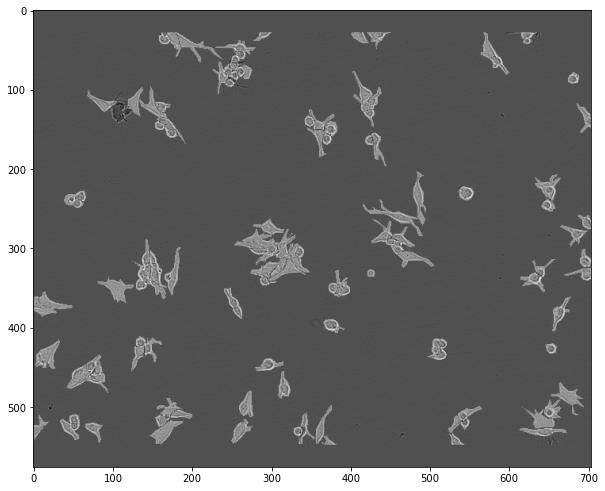

In [31]:
merged = cv2.addWeighted(img, 0.75, 
                             np.clip(np.sum(mask, -1).astype(img.dtype), 0, 1)*255, 0.25, 0.0,)

fig = plt.figure(figsize=(10, 10))
plt.imshow(merged, cmap='gray')

In [35]:
img_id = np.random.choice(train_df['id'], 1)[0]
mask = rle_decode_by_image_id(img_id, train_df)
img = imageio.imread(os.path.join('./train', img_id + '.png'))

In [36]:
mask = livecell_dataset.pad_image(mask, 0)

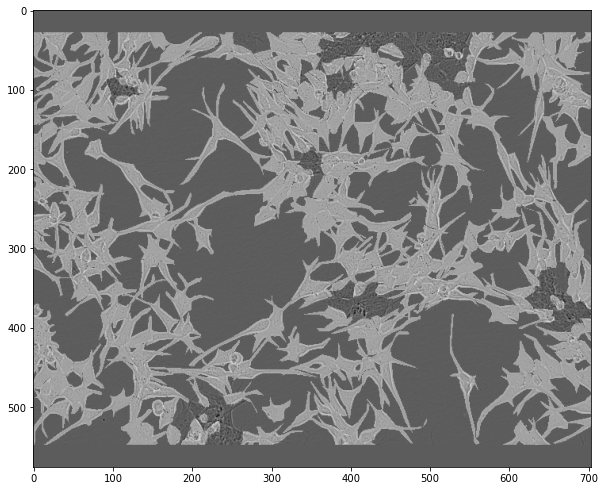

In [37]:
merged = cv2.addWeighted(img, 0.75, 
                             np.clip(np.sum(mask, -1).astype(img.dtype), 0, 1)*255, 0.25, 0.0,)

fig = plt.figure(figsize=(10, 10))
plt.imshow(merged, cmap='gray')

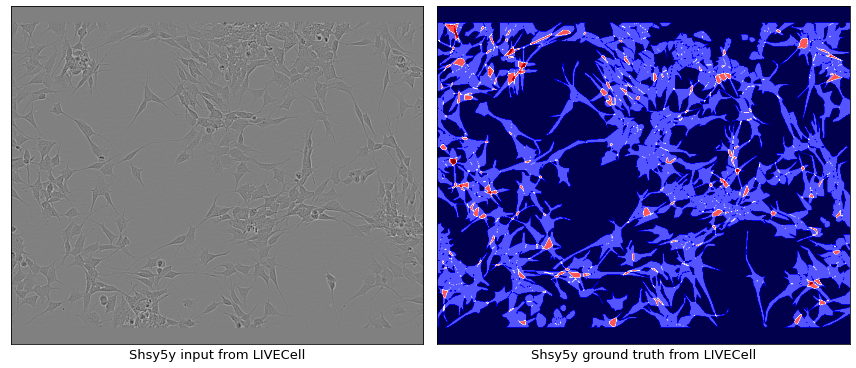

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(12, 12))

axs[0].imshow(img, cmap='gray')
axs[0].set_xlabel('Shsy5y input from LIVECell', fontsize=13)
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(np.sum(mask, -1), cmap='seismic')
axs[1].set_xlabel('Shsy5y ground truth from LIVECell', fontsize=13)
axs[1].set_xticks([])
axs[1].set_yticks([])

plt.tight_layout()
plt.show()